# Analysis of gender distribution in UK's leading newspapers
# Gender representation

## Content
1. [Setup](#setup)   
    1.1 [Global](#global_setup)  
    1.2 [Local](#local_setup)   
2. [Time analysis](#time_analysis)   
    2.1 [Function definitions](#functions)  
    2.2 [Accumulate results](#results)     
3. [Plots](#plots)    
    3.1 [Number of quotes male, female and gender minorities, UK 2019](#nb_quotes)    
    3.2 [Percentage of female quotes and gender minority quotes, UK](#perc_quotes)   
    3.3 [Mean percentage of female and gender minority quotes, UK](#perc_mean)   
    3.4 [Mean percentage of female and gender minority quotes, other countries](#perc_quotes_countries)   
    3.5 [Country averages of female quotes](#country_avg)

## 1. Setup
<a id="setup"></a>

### 1.1 Global
<a id="global_setup"></a>

In [75]:
# Change to true if you want to use google colab
use_colab = True

# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive._mount('/content/drive', force_remount=True)
    %cd /content/drive/Shareddrives/ADA-project
    !pip install pandas==1.0.5 # downgrade pandas for chunk processing support

In [76]:
# Defined paths for the data
from scripts.path_defs import *

# Defined newspapers and urls
from scripts.newspapers import *

# Globally used functions
from scripts.utility_functions import load_mini_version_of_data
from scripts.utility_functions import convert_to_1Dseries
from scripts.utility_functions import process_data_in_chunks

### 1.2 Local 
<a id="local_setup"></a>

In [77]:
import pandas as pd
import numpy as np
import json
import bz2
import statsmodels.api as sm

# Plots
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from itertools import cycle
from IPython.display import Image

## 2. Time analysis
<a id="time_analysis"></a>

In this notebook we will have a first look on the repartition of the speaker's genders, in order to conduct an analysis on the **evolution of women, men and gender diverse individuals' presence in quotes of UK's newspapers**. The statistic of other countries (US, India, Nigeria) are studied as well to allow a comparison.

First of all let's see which genders are present in the Quotebank 2019 dataset:

In [4]:
# Get number of each gender, 2019 as example
df_2019 = pd.read_json(MERGED_QUOTES_UK_2019_PATH, lines=True, compression='bz2')
convert_to_1Dseries(df_2019["gender"]).value_counts()

male                  447917
female                148703
transgender female       692
genderfluid              381
non-binary               333
intersex                 130
cisgender female         118
transgender male          35
genderqueer               13
transgender person         8
shemale                    7
dtype: int64

As expected, the two gender represented the most are male and female. A quick overview of the definition of the all the other genders is given in the lexicon of our data story. For a more meaningful analysis we choose to group them in one single category "other".

### 2.1 Function definitions
<a id="functions"></a>

To construct a time dependent dateset we need to merge all the outputs from the data cleaning process (2015-2020). All this data is to large to fit into memory. We will have to aggregate the results in chunks with our function `process_data_in_cunks` (see _scripts/utility_functions.py_ for more details).

The goal of this processsing is to create a dataframe having the **number of quotes for each day, per gender and newspaper**. The needed functions are:

In [5]:
# As discussed group gender minorities into other
def group_genders(x):
    """Function which groups gender minorites into category 'other'"""
    if len(x)==1:
        if x[0] in ['male', 'female']:
            return x[0]
        else:
            return 'other'
    else:
        return 'other'

# The aggregation function which is passed to process_data_in_chunks
def get_gender_counts(chunk, gender_repr_df, year):
    """Aggregate gender counts per day. This function is passed to process_data_in_chunks.
    
    Arguments:
        chunk (df): Chunk of one year
        gender_repr_df (df): The Dataframe where results are accumulated.
        year (int): Year of chunk which will be processed.
    Returns:
        gender_repr_df
    
    """
    # Apply gender grouping into male, female and other
    chunk['gender'] = chunk.gender.apply(group_genders)
    
    # Create dummy columns to aggregate counts
    # Per quote:
    dummies_df = pd.get_dummies(chunk['gender'],prefix='counts')
    # Using number of occurrences
    dummies_occ_df = pd.get_dummies(chunk['gender'],prefix='counts_occ').mul(chunk.numOccurrences, 0)
    chunk = pd.concat([chunk, dummies_df, dummies_occ_df], axis=1)
    
    # Create datetime column and set as index
    chunk['date'] = pd.to_datetime(chunk['date'], yearfirst=True)
      
    # Aggregate quote counts for every newspaper
    for newspaper in newspapers_df['name']:
        # Select quotes from one newspaper
        mask_newspaper = chunk.newspapers.apply(lambda x: newspaper in x)
        newspaper_df = chunk[mask_newspaper]
        
        # Aggregate quote counts per day and gender
        newspaper_df = newspaper_df.resample('D', on='date').sum()
        newspaper_df.drop('numOccurrences', axis=1, inplace=True) # remove now useless column
        newspaper_df.insert(0, 'newspaper', newspaper) # insert newspaper name
        
        newspaper_df.reset_index(inplace=True) # to be able to append
        gender_repr_df = gender_repr_df.append(newspaper_df, ignore_index=True)
    
    # Aggregate sums after chunk is processed
    gender_repr_df = gender_repr_df.groupby(['date','newspaper']).sum().reset_index()
    
    return gender_repr_df

In [6]:
def create_gender_representation(country_string):
    """Function which loops through all the years of one country and accumulates results in chunks."""
    years = [2015, 2016, 2017, 2018, 2019, 2020]
    gender_repr_df = pd.DataFrame()
    
    for year in years:
        path_to_file = globals()['MERGED_QUOTES_' + country_string + '_' + str(year) + '_PATH']
        gender_repr_df = process_data_in_chunks(path_to_file, get_gender_counts, gender_repr_df, year, use_colab)
        print(str(year) + ' finished')

    return gender_repr_df

### 2.2 Accumulate results
<a id="results"></a>

Using the defined functions we can accumulate the number of quotes for each country. The results are saved to the folder _Results_.

In [ ]:
# Dataframe of newspapers for uk
# which is passed implicitly to function!
newspapers_df = pd.DataFrame(newspapers_uk_list, columns=['name', 'website_url'])

# Add per day statistics of for gender
gender_df_repr = create_gender_representation('UK')

# Save results as pickle
gender_df_repr.to_pickle(GENDER_REPRESENTATION_UK_2015_TO_2020_PATH)

2015 finished
2016 finished
2017 finished
2018 finished
2019 finished
2020 finished


For US:

In [ ]:
newspapers_df = pd.DataFrame(newspapers_us_list, columns=['name', 'website_url'])
gender_repr_df = create_gender_representation('US')
gender_repr_df.to_pickle(GENDER_REPRESENTATION_US_2015_TO_2020_PATH)

For India:

In [ ]:
newspapers_df = pd.DataFrame(newspapers_in_list, columns=['name', 'website_url'])
gender_repr_df = create_gender_representation('IN')
gender_repr_df.to_pickle(GENDER_REPRESENTATION_IN_2015_TO_2020_PATH)

For Nigeria:

In [ ]:
newspapers_df = pd.DataFrame(newspapers_ng_list, columns=['name', 'website_url'])
gender_repr_df = create_gender_representation('NG')
gender_repr_df.to_pickle(GENDER_REPRESENTATION_NG_2015_TO_2020_PATH)

## 3 Plots
<a id="plots"></a>

Let us create some plots now. Each subsection will create interactive plots using the library `plotly`. These plots are not visible in the html of this notebook. We will provide an image of each plot for readability.

In [78]:
# Load from Results folder
newspapers_uk_df = pd.DataFrame(newspapers_uk_list, columns=['name', 'website_url'])
gender_repr_uk_df = pd.read_pickle(GENDER_REPRESENTATION_UK_2015_TO_2020_PATH)

newspapers_us_df = pd.DataFrame(newspapers_us_list, columns=['name', 'website_url'])
gender_repr_us_df = pd.read_pickle(GENDER_REPRESENTATION_US_2015_TO_2020_PATH)

newspapers_in_df = pd.DataFrame(newspapers_in_list, columns=['name', 'website_url'])
gender_repr_in_df = pd.read_pickle(GENDER_REPRESENTATION_IN_2015_TO_2020_PATH)

newspapers_ng_df = pd.DataFrame(newspapers_ng_list, columns=['name', 'website_url'])
gender_repr_ng_df = pd.read_pickle(GENDER_REPRESENTATION_NG_2015_TO_2020_PATH)

### 3.1 Number of quotes male, female and gender minorities, UK 2019
<a id="#nb_quotes"></a>
The two following bar plot display the **number of quotes per gender and newspaper for one year**. As an example we will use 2019 because it is the most recent and complete year. As a side note: the plots for other years look very similar!

In [79]:
# Set color palette
palette_values = px.colors.qualitative.Pastel
palette = cycle(palette_values)

# Bar plot male vs female for all UK newspapers
x = newspapers_uk_df['name'].to_list()
y = gender_repr_uk_df[gender_repr_uk_df['date'].dt.year == 2019]

y = y.groupby('newspaper').sum()
y = y.loc[x] # sort

y1 = y['counts_male']
y2 = y['counts_female']

fig = go.Figure(go.Bar(x=x, y=y1, name='Male quotes', marker_color=next(palette)))
fig.add_trace(go.Bar(x=x, y=y2, name='Female quotes', marker_color=next(palette)))

fig.update_layout(barmode='stack',
                  xaxis={'categoryorder':'total descending'},
                  xaxis_title="Newspaper", yaxis_title="Number of quotes",
                  title_text="Number of quotes, male and female, UK (2019)",
)
fig.show()
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/counts_male_female_uk_2019.html", full_html=False, include_plotlyjs='cdn')


# Set color palette
palette_values = px.colors.qualitative.Pastel
palette = cycle(palette_values)

x = newspapers_uk_df['name'].to_list()
y = gender_repr_uk_df[gender_repr_uk_df['date'].dt.year == 2019]

y = y.groupby('newspaper').sum()
y = y.loc[x] # sort

y1 = y['counts_occ_male']
y2 = y['counts_occ_female']

fig = go.Figure(go.Bar(x=x, y=y1, name='Male quotes', marker_color=next(palette)))
fig.add_trace(go.Bar(x=x, y=y2, name='Female quotes', marker_color=next(palette)))

fig.update_layout(barmode='stack',
                  xaxis={'categoryorder':'total descending'},
                  xaxis_title="Newspaper", yaxis_title="Number of occurrences of quotes",
                  title_text="Number of occurrences of quotes, male and female, UK (2019)",
)
fig.show()


# Bar plot other genders for all UK newspapers
y3 = y['counts_other']

fig = go.Figure(go.Bar(x=x, y=y3, marker_color=next(palette), name='Gender minorites quotes'))

fig.update_layout(barmode='stack',
                  xaxis={'categoryorder':'total descending'},
                  xaxis_title="Newspaper", yaxis_title="Number of quotes",
                  title_text="Number of quotes, gender minorities, UK (2019)",
                 
)
fig.show()
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/counts_other_uk_2019.html", full_html=False, include_plotlyjs='cdn')

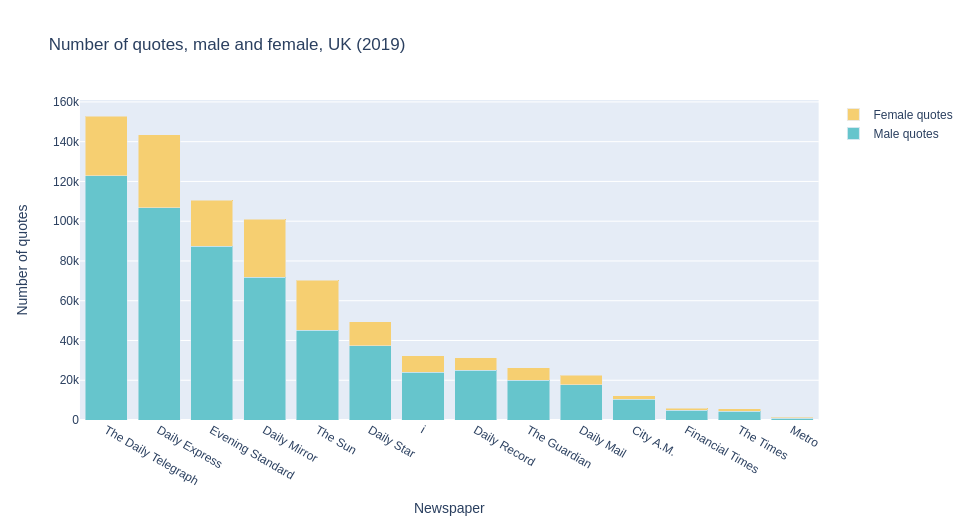

In [10]:
Image(filename='docs/imgs/counts_male_female_uk_2019.png') # for github

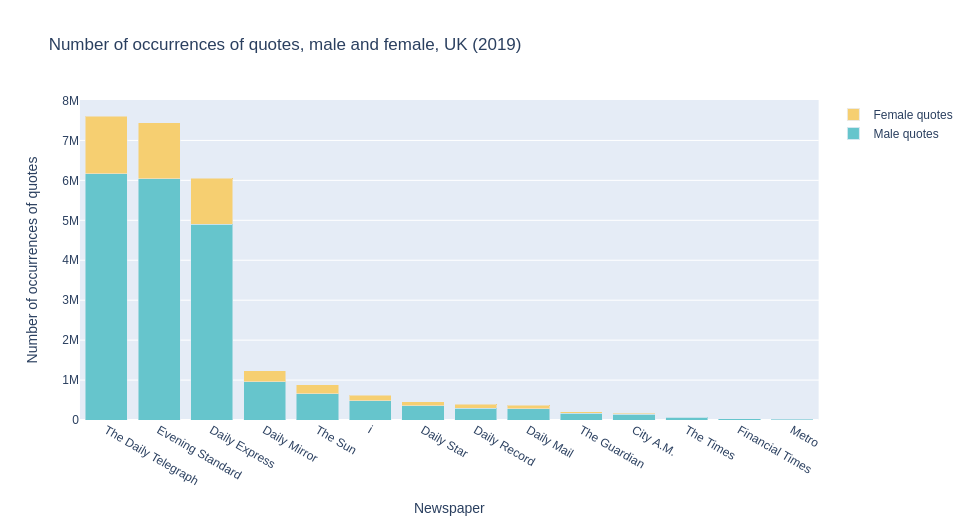

In [11]:
Image(filename='docs/imgs/counts_occ_male_female_uk_2019.png') # for github

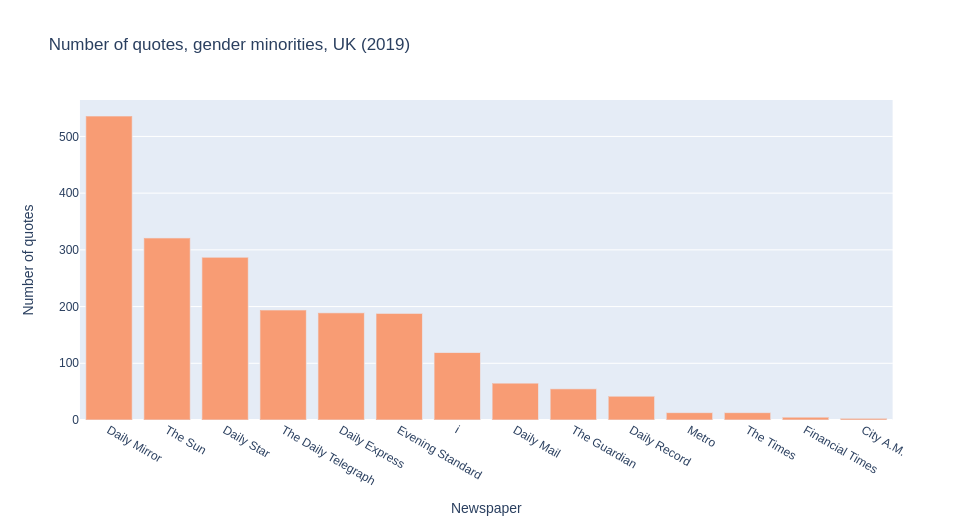

In [12]:
Image(filename='docs/imgs/counts_other_uk_2019.png') # for github

Ok, so what are the insights:
* In general (even after choosing the journals with most circulation) there is a difference in number of quotes per year.
* We can see in the first plot that **the equality of the population of men and women is not at all represented in citations**. This difference holds for any newspaper from the tabloids to more serious daily journals.
* We have chosen the Uk's newspapers regarding their circulation and not their online diffusion. Interestingly the most circulated journal **Metro** seems to have nearly no captured data in the Quotebank dataset.
* Since we were given the number of occurrences for each quotes. We can output the same plot using the accumulated number of occurrences (the second plot). We were hoping to see some additional information on the impact of a quote. It seems that the gap in gender representation holds. But we can not affirm more because of inconsistency between the journals and how they spread information.

### 3.2 Percentage of female quotes and gender minority quotes, UK
<a id="perc_quotes"></a>

Now we will have a look at the percentage of a gender. This analysis will be done on a monthly rate to create meaningful plots. 

In [21]:
# Set color palette
palette_values = px.colors.qualitative.Pastel + px.colors.qualitative.Pastel2
palette_values = palette_values[3:]
palette = cycle(palette_values)

# Line plot female fraction 2015-2020 for UK
month_df = gender_repr_uk_df.groupby('newspaper').resample('M', on='date').sum().reset_index()
#month_df = month_df.loc[month_df['date'].dt.year>=2017] # for plot on website, see discussion below
month_df['date'] = month_df['date'].dt.strftime("%Y-%m")

month_df['perc_female'] = month_df['counts_female'] / (month_df['counts_female'] + month_df['counts_male'] + month_df['counts_other']) * 100
month_df['counts_total'] = month_df['counts_female'] + month_df['counts_male'] + month_df['counts_other']

fig = px.line(month_df, x='date', y='perc_female', color='newspaper', custom_data=['counts_female', 'counts_total'], color_discrete_sequence=palette_values,
                labels={
                     'perc_female': "Female quotes [%]",
                     'date': "Year",
                     'newspaper': "Newspaper"},)

fig.update_layout(barmode='stack',
                  title_text="Percentage of female quotes in UK's newspaper, 2015-2020",
                  #title_text="Percentage of female quotes in UK's newspaper, 2017-2020",
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Female quotes [%]: %{y}",
        "Month: %{x}",
        "Female counts: %{customdata[0]}",
        "Total counts: %{customdata[1]}",
    ])
)
fig.show()
#fig.to_html(full_html=False, include_plotlyjs='cdn')  
#fig.write_html("docs/_includes/perc_female_uk_allyears.html", full_html=False, include_plotlyjs='cdn')


# Set color palette
palette_values = px.colors.qualitative.Pastel + px.colors.qualitative.Pastel2
palette_values = palette_values[3:]
palette = cycle(palette_values)

# Line plot gender minorities fraction 2015-2020 for UK
month_df['perc_other'] = month_df['counts_other'] / (month_df['counts_female'] + month_df['counts_male'] + month_df['counts_other']) * 100
other_quotes = month_df.loc[month_df['counts_other'] != 0]

fig = px.line(other_quotes, x='date', y='perc_other', color='newspaper', custom_data=['counts_other', 'counts_total'], color_discrete_sequence=palette_values,
                labels={
                     'perc_other': "Gender minority quotes [%]",
                     'date': "Year",
                     'newspaper': "Newspaper"},)

fig.update_layout(barmode='stack',
                  title_text="Percentage of gender minority quotes in UK's newspaper, 2015-2020",             
)
fig.update_traces(
    hovertemplate="<br>".join([
        "Gender minority quotes [%]: %{y}",
        "Month: %{x}",
        "Gender minority counts: %{customdata[0]}",
        "Total counts: %{customdata[1]}",
    ])
)
fig.show()

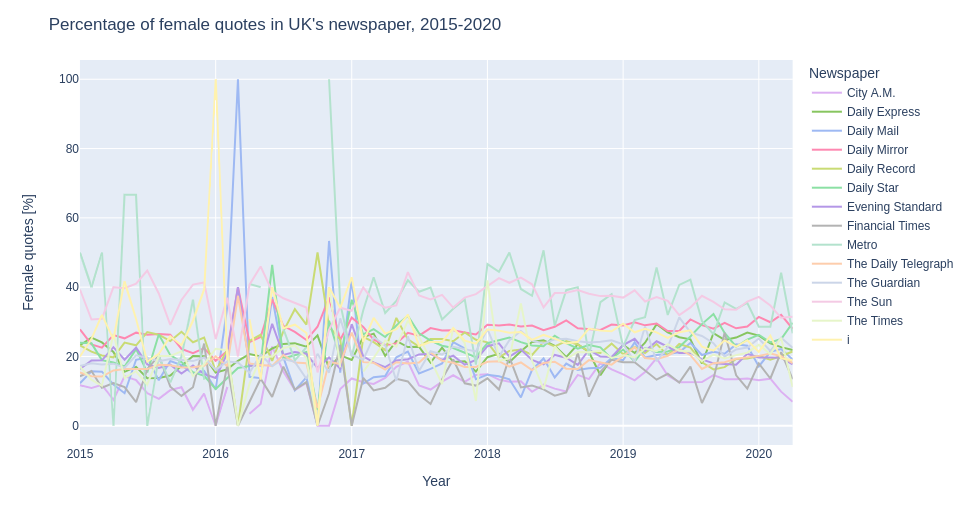

In [22]:
Image(filename='docs/imgs/perc_female_uk_allyears.png') # for github

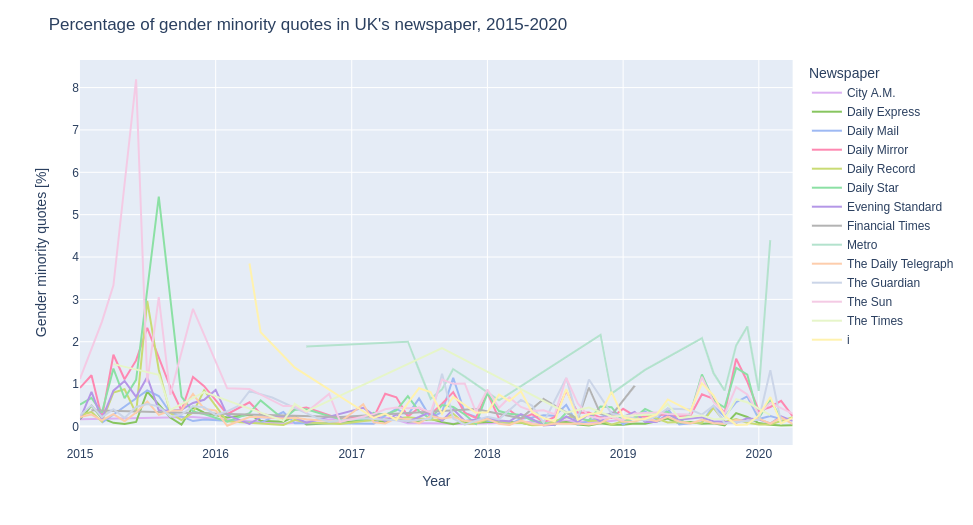

In [23]:
Image(filename='docs/imgs/perc_other_uk_allyears.png') # for github

Some newspapers don't have a lot of data in the range of 2015 to 2016. This explains these large peaks since we are looking at fractions. For example the newspaper **i** has 100% female quotes in January 2016. The cause is that there are just 2 quotes in total and both are by chance women. This really doesn't display anything of importance. This effect is even worse in the gender minorities plot.

For a further analysis and better reading in the data story we will only take into account 2017 upto 2020. The 5-year span was already too short to display an evolution in time, thus the assumption of this new span won't make a lot of a difference for our conclusion.

The main take-away seems to be:
**Disparity remains more or less constant throughout the 5 years span.** We don't see any clear evolution.

Let's back up this claim:

**Null hypothes**: No linear dependency between time and percentage of female quotes of a newspaper
    (Note: we just check for linear dependence).
    
Let's create a stats model for each newspaper and check the P-Values and check for years 2017-2020.

In [80]:

for n in newspapers_uk_df['name']:
    month_df = gender_repr_uk_df.groupby('newspaper').resample('M', on='date').sum().reset_index()
    month_df = month_df.loc[month_df['date'].dt.year>=2017] # ... for no nan values in The Times set 2018

    month_df['perc_female'] = month_df['counts_female'] / (month_df['counts_female'] + month_df['counts_male'] + month_df['counts_other']) * 100
    month_df = month_df.loc[month_df['newspaper'] == n]

    x = pd.to_datetime(month_df['date'], yearfirst=True).view(int) // 10 ** 9
    y = month_df['perc_female']

    x = sm.add_constant(x) # adding a constant

    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 
    
    print(n)
    print(model.summary())
    #print(model.pvalues)
    print()
    print()

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



The Sun
                            OLS Regression Results                            
Dep. Variable:            perc_female   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     6.840
Date:                Fri, 17 Dec 2021   Prob (F-statistic):             0.0127
Time:                        11:57:09   Log-Likelihood:                -97.713
No. Observations:                  40   AIC:                             199.4
Df Residuals:                      38   BIC:                             202.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.7122     22.877      4.228 

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



Metro
                            OLS Regression Results                            
Dep. Variable:            perc_female   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.4826
Date:                Fri, 17 Dec 2021   Prob (F-statistic):              0.491
Time:                        11:57:09   Log-Likelihood:                -138.85
No. Observations:                  40   AIC:                             281.7
Df Residuals:                      38   BIC:                             285.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.6602     63.979      1.245   

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



The Daily Telegraph
                            OLS Regression Results                            
Dep. Variable:            perc_female   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.5210
Date:                Fri, 17 Dec 2021   Prob (F-statistic):              0.475
Time:                        11:57:09   Log-Likelihood:                -84.104
No. Observations:                  40   AIC:                             172.2
Df Residuals:                      38   BIC:                             175.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1004     16.279

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



i
                            OLS Regression Results                            
Dep. Variable:            perc_female   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     12.70
Date:                Fri, 17 Dec 2021   Prob (F-statistic):            0.00101
Time:                        11:57:09   Log-Likelihood:                -104.72
No. Observations:                  40   AIC:                             213.4
Df Residuals:                      38   BIC:                             216.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.1439     27.254      4.518      0

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/moritz/.conda/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



Interesting...

* Setting **alpha=0.01 (1%)** we have that the null **hypothesis could (P-Values >= 0.01) explain the data** for almost all the newspapers.

* The 4 newspapers where there could be **no linear independence: Daily Mail, Daily Record, i, The Sun**

For now we will make an average over all years to compare the different newspaper. We will come back to this in section 3.5 where will compare different countries over time.

### 3.3 Mean percentage of female and gender minority quotes, UK
<a id="perc_mean"></a>

The hypothesis testing in section 3.2 that it makes sence to do a time independent analysis first. The next plots use thus the 5-year span to create an average.

In [81]:
# Set color palette
palette_values = px.colors.qualitative.Pastel
palette = cycle(palette_values)

y = gender_repr_uk_df.groupby('newspaper').sum().reset_index()
y['perc_female'] = y['counts_female'] / (y['counts_female'] + y['counts_male'] + y['counts_other']) * 100

# Bar plot percentage female quotations for 2015-2020
x = newspapers_uk_df['name'].to_list()
y1 = y['perc_female']

fig = go.Figure(go.Bar(x=x, y=y1, marker_color=palette_values[1], name='Female percentage'))

fig.update_layout(barmode='stack',
                  xaxis={'categoryorder':'total descending'},
                  xaxis_title="Newspaper", yaxis_title="Female quotes [%]",
                  title_text="Mean percentage of female quotes, UK (2015-2020)",
                 
)
fig.show()
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/perc_female_uk_means.html", full_html=False, include_plotlyjs='cdn')



# Set color palette
palette_values = px.colors.qualitative.Pastel
palette = cycle(palette_values)

y['perc_other'] = y['counts_other'] / (y['counts_female'] + y['counts_male'] + y['counts_other']) * 100

# Bar plot percentage other quotations for 2015-2020
x = newspapers_uk_df['name'].to_list()
y1 = y['perc_other']

fig = go.Figure(go.Bar(x=x, y=y1, marker_color=palette_values[2], name='Gender minorities percentage'))

fig.update_layout(barmode='stack',
                  xaxis={'categoryorder':'total descending'},
                  xaxis_title="Newspaper", yaxis_title="Gender minority quotes [%]",
                  title_text="Mean percentage of gender minority quotes, UK (2015-2020)",
                 
)
fig.show()
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/perc_other_uk_means.html", full_html=False, include_plotlyjs='cdn')

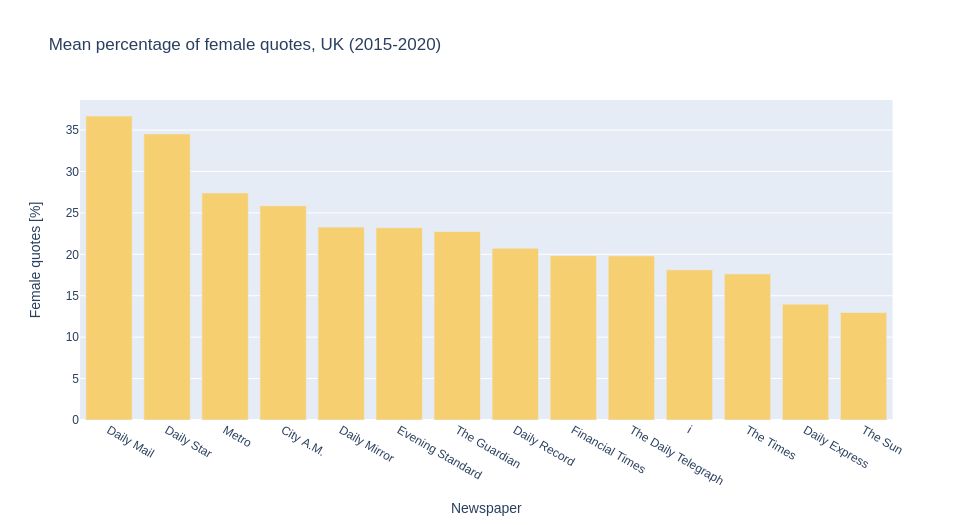

In [25]:
Image(filename='docs/imgs/perc_female_uk_means.png') # for github

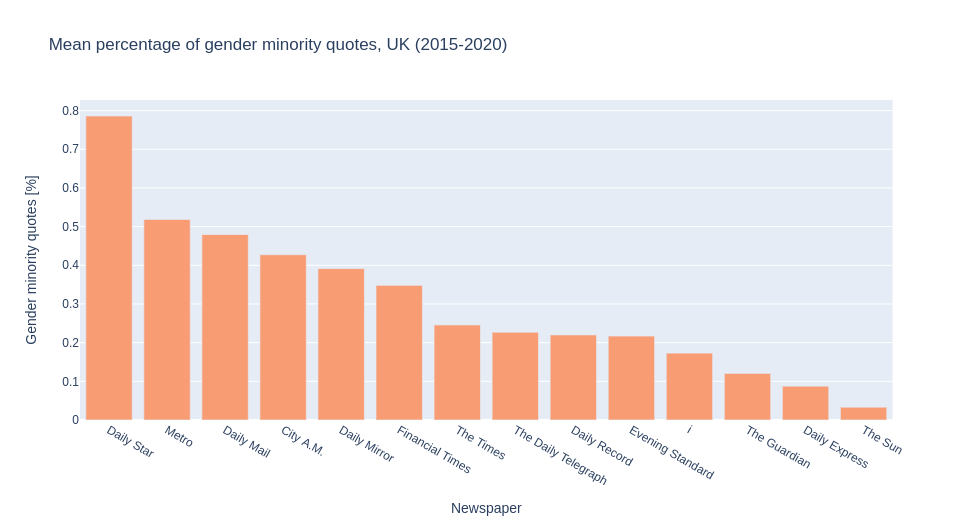

In [26]:
Image(filename='docs/imgs/perc_other_uk_means.png') # for github

What can we state?
* Females are best represented in **Daily Mail** and **Daily Star** which are both tabloid newspapers with around 35% of female quotes.
* It seems that no conclusion nor link can be made between the newspaper theme and the women's representation.
* There seems to be a tendency perhaps regarding the publisher for each journal which is not necessarily linked to their content.
* From 3.2 we know that this tendency remains constant over the years
* We don't know if gender minorities are underrepresented. The percentage fluctuates from 0.05 -0.8 % which corresponds to their distrubution in the population (0.1-2%, estimation from a survey conducted in 2011 by the Equality and Human Rights Commission, see more details in our data story, see data story).

### 3.4 Mean of female and gender minority quotes, other countries
<a id="perc_quotes_countries"></a>

As a next step let's have a look at the gender distribution in the newspapers of other English-speaking countries. We will omit the time independence analysis for these countries. Using the same code as for the UK's some tests have show similar trends as for the UK. Let us look the averages over the time span of the 5 years.

In [82]:
# Set color palette
palette_values = px.colors.qualitative.Pastel
palette = cycle(palette_values)

# Create list of dataframes for US, IN and NG
newspapers_list = [newspapers_us_df, newspapers_in_df, newspapers_ng_df]
gender_repr_list = [gender_repr_us_df, gender_repr_in_df, gender_repr_ng_df]

# Bar plot percentage female quotations for 2015-2020, other countries
fig = make_subplots(rows=3, cols=1, subplot_titles=('US', 'India', 'Nigeria'),
                    vertical_spacing=0.13,
                    shared_yaxes='all'
)

for i, (y, n) in enumerate(zip(gender_repr_list, newspapers_list)):
    y = y.groupby('newspaper').sum().reset_index()
    x = n['name'].to_list()
    y1 = y['counts_female'] / (y['counts_female'] + y['counts_male'] + y['counts_other']) * 100

    fig.append_trace(go.Bar(x=x, y=y1, marker_color=palette_values[1], name='Female percentage'),
                     row=(i+1), col=1)

fig.update_layout(barmode='stack',
                                    xaxis={'categoryorder':'total descending'},
                  xaxis2={'categoryorder':'total descending'},
                  xaxis3={'categoryorder':'total descending'},
                  xaxis4={'categoryorder':'total descending'},
                  title_text="Percentage of female quotes (2015-2020)",
                  showlegend=False,
)

fig.show()
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/perc_female_countries_means.html", full_html=False, include_plotlyjs='cdn')


# Bar plot percentage other quotations for 2015-2020, other countries
fig = make_subplots(rows=3, cols=1, subplot_titles=('US', 'India', 'Nigeria'),
                    vertical_spacing=0.13,
                    shared_yaxes='all'
)

for i, (y, n) in enumerate(zip(gender_repr_list, newspapers_list)):
    y = y.groupby('newspaper').sum().reset_index()
    x = n['name'].to_list()
    y1 = y['counts_other'] / (y['counts_female'] + y['counts_male'] + y['counts_other']) * 100

    fig.append_trace(go.Bar(x=x, y=y1, marker_color=palette_values[2], name='Gender minorities percentage'),
                     row=(i+1), col=1)
    fig.update_layout(xaxis={'categoryorder':'total descending'})

fig.update_layout(barmode='stack',
                  xaxis={'categoryorder':'total descending'},
                  xaxis2={'categoryorder':'total descending'},
                  xaxis3={'categoryorder':'total descending'},
                  xaxis4={'categoryorder':'total descending'},
                  title_text="Percentage of gender minority quotes (2015-2020)",
                  showlegend=False,
)
fig.show()
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/perc_other_countries_means.html", full_html=False, include_plotlyjs='cdn')

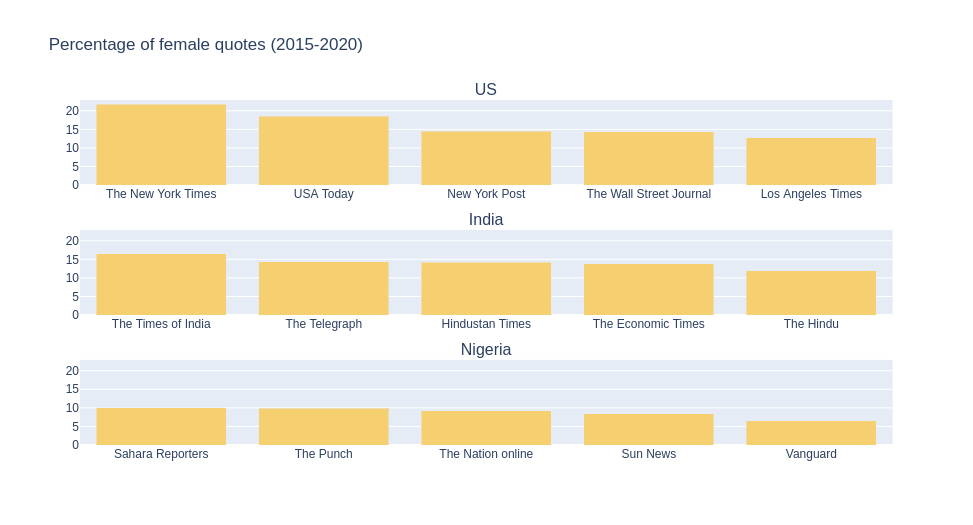

In [28]:
Image(filename='docs/imgs/perc_female_countries_means.png') # for github

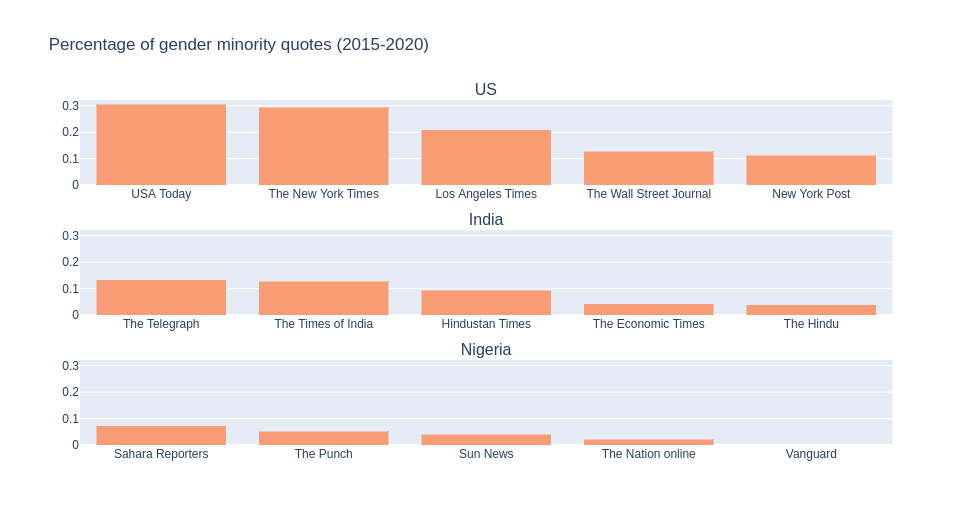

In [29]:
Image(filename='docs/imgs/perc_other_countries_means.png') # for github

Even if we cannot issue a conclusion for the different newspapers of a same country, we can see a **difference in the distribution of genders between countries**. We can clearly see that India and Nigeria have lower propotion than the US and UK. This can be justified by the history of the country and their consideration for women and gender minorities which is reflected in the results we obtained.

### 3.5 Country averages (from all newspapers) of female quotes
<a id="country_avg"></a>
In contrast to the analysis in section 3.3 we now average over all the newspapers per country. Maybe there will be some evolution in time?!

In [74]:
# Set color palette
palette_values = px.colors.qualitative.Pastel
palette_values = palette_values[3:]
palette = cycle(palette_values)


# Create list of dataframes for UK, US, IN and NG
countries_list = ['UK', 'US', 'India', 'Nigeria']
gender_repr_list = [gender_repr_uk_df, gender_repr_us_df, gender_repr_in_df, gender_repr_ng_df]

fig = make_subplots(rows=1, cols=1)

countries_df = pd.DataFrame(columns=['date', 'counts_female', 'counts_male', 'counts_other',
                                     'counts_occ_female', 'counts_occ_male', 'counts_occ_other',
                                    'perc_female', 'counts_total', 'country'])
for i, (y, c) in enumerate(zip(gender_repr_list, countries_list)):
    month_df = y.resample('M', on='date').sum().reset_index()
    month_df['perc_female'] = month_df['counts_female'] / (month_df['counts_female'] + month_df['counts_male'] + month_df['counts_other']) * 100
    month_df['counts_total'] = month_df['counts_female'] + month_df['counts_male'] + month_df['counts_other']
    month_df['country'] = c
    countries_df = pd.concat([countries_df, month_df], axis=0)

fig = px.scatter(countries_df, x='date', y='perc_female', color='country', 
              color_discrete_sequence=palette_values, trendline="ols",
            labels={
                     'perc_female': "Female quotes [%]",
                     'date': "Year",
                     'country': "Country"},)

fig.update_layout(barmode='stack',
                  title_text="Female quotes country averages, 2015-2020",             
)
fig.show()
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/perc_female_countries_allyears.html", full_html=False, include_plotlyjs='cdn')

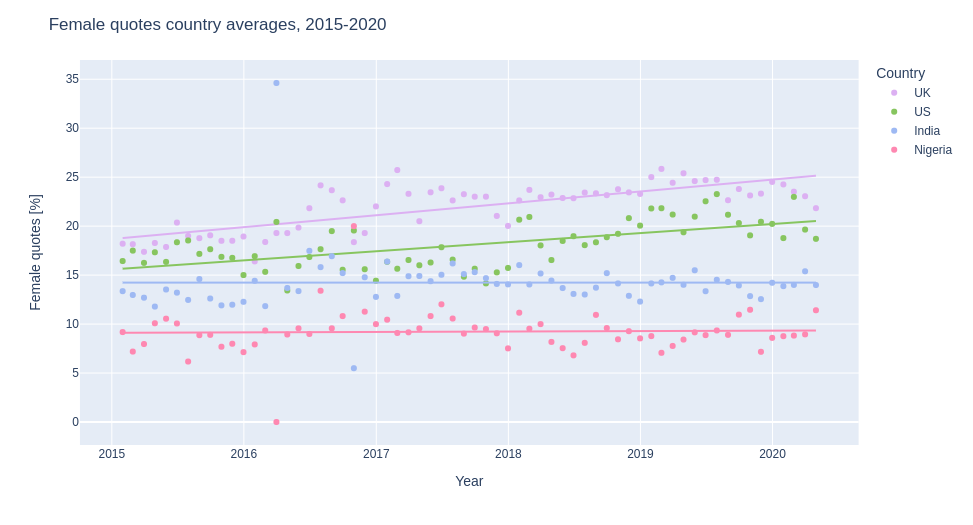

In [33]:
Image(filename='docs/imgs/perc_female_countries_allyears.png') # for github



We can finally see some evolution in time but only for the US and UK. (The $R^{2}$ for the regression line for both Nigeria and India is almost 0). This supports the hypothesis that in the last decades, women and gender diverse individuals' rights and voices have gained awareness and freedom. And this progression is also captured in the newspaper. On the other hand the process is still very slow depending on the countries and their society.